<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/04-model-quantization/01_gpt_2_sm_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantization of the GPT-2 Small Model

The code in this notebook is to introduce readers to the quantization of a decoder-only language model, [GPT-2 Small](https://huggingface.co/openai-community/gpt2). It doesn't require hardware acceleration.  


Import the required packages and classes.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## Quantization method

There are multiple potential approaches to
quantization. Among these, the most used are zero-point and absmax.

###zero-point method

Imagine we want to convert a fp32 tensor to int8.

In case of zero-point quantization, we scale them by the total range of values for int8 (255) divided by the
difference between the maximum and minimum values of the inputs(X).

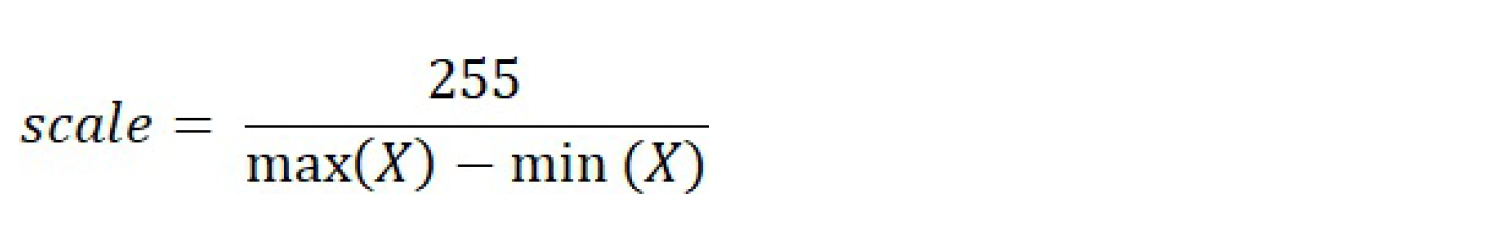

The scaled distribution is then shifted to map it into the [-127, 128] range:
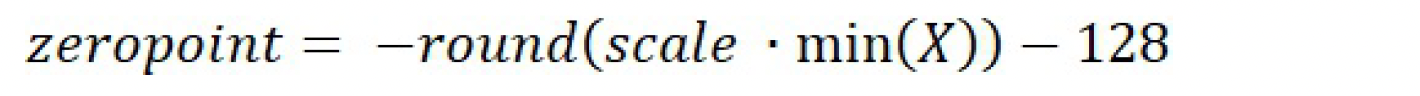

The calculated scale and zeropoint values are finally used to quantize or dequantize a model’s weights:

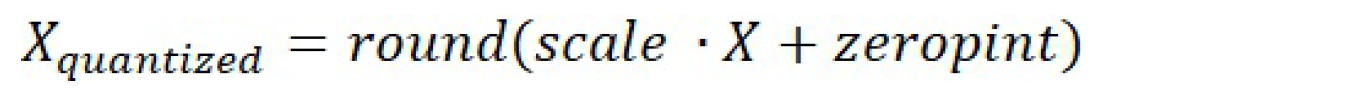

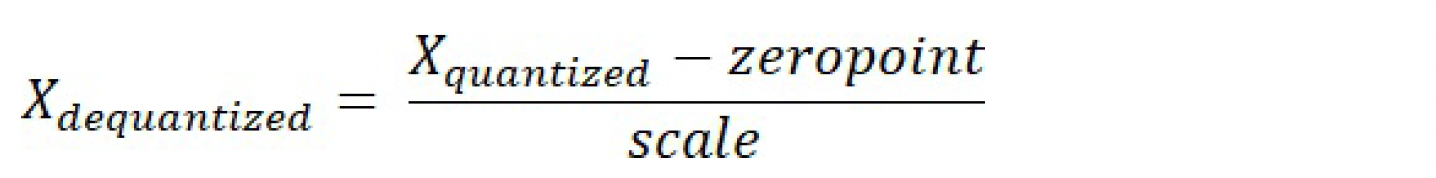

Now, imagine the minimum value is -4.0 and the maximum value is 4.1.

In [ ]:
scale_value = round(255 / (4.1 - (-4.0)), 2)
print(scale_value)

31.48


In [ ]:
zero_point_value = -round(scale_value * (-4.0)) - 128
print(zero_point_value)

-2


Assuming we have a weight of let’s say 0.2.

In [ ]:
quantized_value = round(scale_value * 0.2 + zero_point_value)
print(quantized_value)

4


In [ ]:
dequantized_value = (quantized_value - zero_point_value) / scale_value
print(dequantized_value)

0.1905972045743329


By dequantizing it, we have obtained 0.19: not exactly the same original weight, as quantization isn’t a lossless operation, but very close to it.

### absmax method

In case of absmax quantization, the original value of an input is divided by
the absolute maximum value of the tensor it belongs to and then multiplied
by a scaling factor (127) to map the input values into the [-127, 127] range:

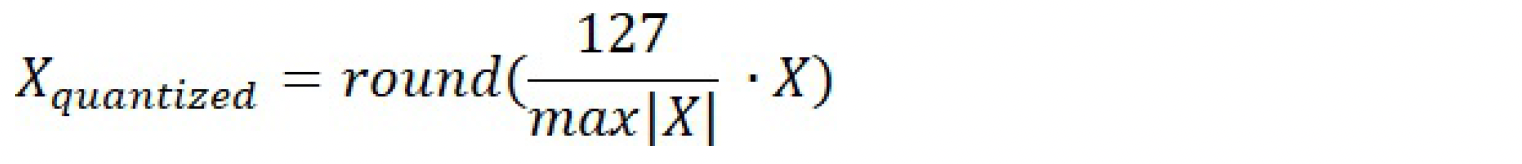

To dequantize:
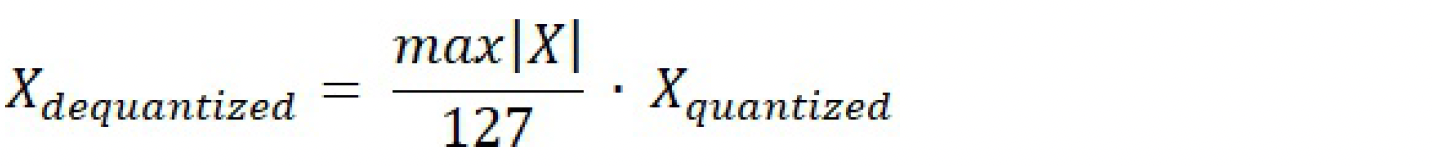

Again, assuming the same maximum value as for the previous zero-point example (4.1) and a weight of 0.2.

In [ ]:
quantized_value = round((127 / abs(4.1)) * 0.2)
print(quantized_value)

6


In [ ]:
dequantized_value = (abs(4.1)/127) * quantized_value
print(dequantized_value)

0.19370078740157481


## Load Model

Download the GPT-2 Small model and associated tokenizer from the HF's Hub and load it to CPU. Finally print the size (in bytes) of the model in memory.

In [ ]:
device = 'cpu'

# Let’s load the model in fp32 from the HF Hub the usual way
model_id = 'openai-community/gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


In [ ]:
print(f"Model size: {int(model.get_memory_footprint()/1024/1024)} GB")

Model size: 486 GB


##absmax quantization

Define a custom function to perform *absmax* quantization and dequantization.

In [ ]:
def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

Clone the source model and apply the previously defined quantization function to all the weights of the cloned copy.

In [ ]:
import numpy as np
from copy import deepcopy

weights = [param.data.clone() for param in model.parameters()]

model_abs = deepcopy(model)

weights_abs = []
for param in model_abs.parameters():
    # quantize/dequantize all the GPT-2 model weights
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

## Visualize weights distribution

Using the matplotlib library, plot the distribution of the weights for the source model and the quantized version both on the same histogram chart.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])

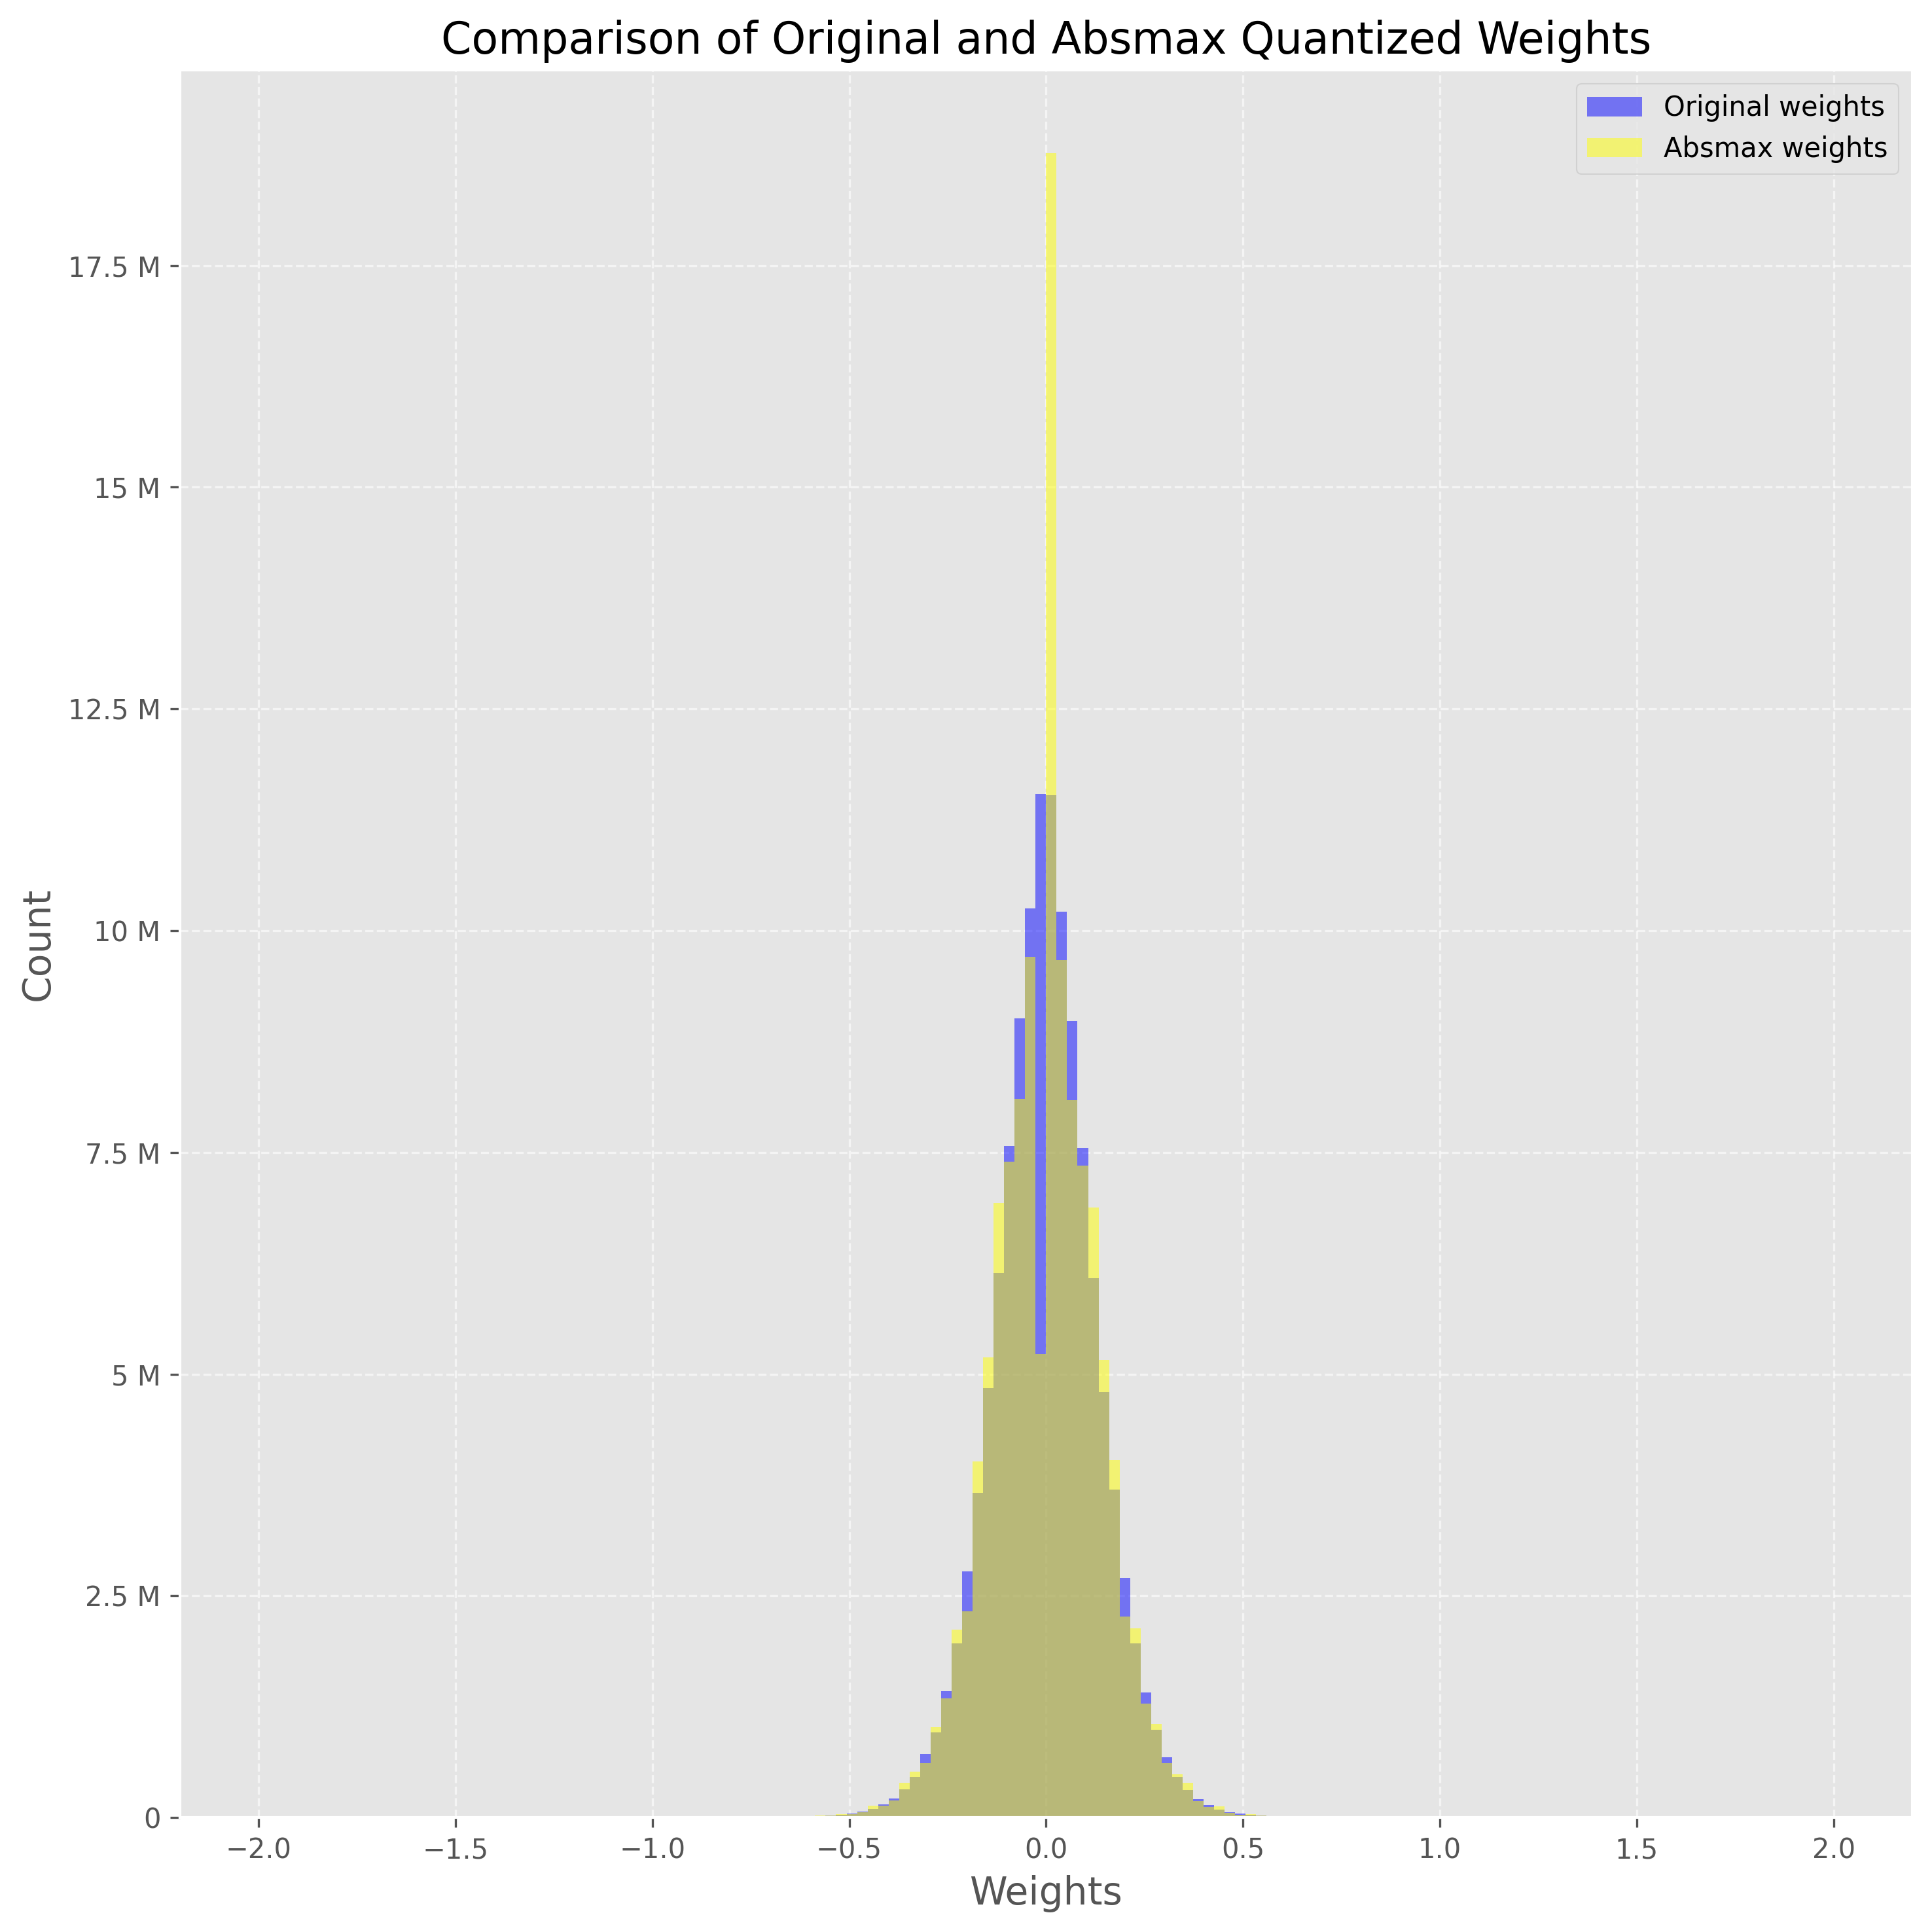

In [ ]:
# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(1, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs.hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs.hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='yellow', range=(-2, 2))

# Add grid
axs.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs.legend()

# Add title and labels
axs.set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)

axs.set_xlabel('Weights', fontsize=14)
axs.set_ylabel('Count', fontsize=14)
axs.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

## Inference

Define a function to generate text, whatever the model (original or quantized).

In [ ]:
def generate_text(model, input_text, max_length=100):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

Use the text generation function defined in the previous code cell to generate text with both model versions (the original and the one after quantization).

In [ ]:
# Let’s see how performance are affected by this process
prompt = 'My favourite school subject is'
original_text = generate_text(model, prompt)
absmax_text   = generate_text(model_abs, prompt)

print(f"Original model:\n{original_text}")
print(f"\nAbsmax model:\n{absmax_text}")

Original model:
My favourite school subject is the science of evolution or the evolution of life itself," said Dr Robert Wood, a professor of biology at the University of Oxford.

"We all know that human evolution is much more complex than that," added Stephen J. Watson of University College London. "The same applies for evolutionary theory."

Absmax model:
My favourite school subject is art, and it comes to mind when looking past some of the most beautiful things in all of time. We get a lot of stuff here that doesn't fit into the timeline of history.

I'd like to see some real art from this world, and this game takes it further than just asking us not to explore. The developers have chosen to use music to inspire the setting.

"There are too many artists out there, and we should focus on creating


## Calculate perplexity

Define a function to calculate the perplexity score.

In [ ]:
def calculate_perplexity(model, text, device):
  # encodes the input sequence
  encodings = tokenizer(text, return_tensors='pt').to(device)

  # define the input and label for the model
  input_ids = encodings.input_ids
  target_ids = input_ids.clone()

  with torch.no_grad():
    # generate text
    outputs = model(input_ids, labels=target_ids)

  # gets the loss
  neg_log_likelihood = outputs.loss

  # calculate the perplexity score
  perplexity = torch.exp(neg_log_likelihood)

  return perplexity

Calculate the perplexity score for both versions of the model, using the text results previously generated by both.

In [ ]:
perplexity = calculate_perplexity(model, original_text, device)
perplexity_absmax = calculate_perplexity(model_abs, absmax_text, device)

print(f"Original perplexity:  {perplexity.item():.2f}")
print(f"Absmax perplexity:    {perplexity_absmax.item():.2f}")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Original perplexity:  12.24
Absmax perplexity:    20.15


We can see that the perplexity of the quantized model is higher than the other in this example.

Of course, a single experiment is not too much reliable: you
should repeat this process multiple times to understand what the difference between each model is.